![digitizing_team](digitizing_team.png)


DigiNsure Inc. is an innovative insurance company focused on enhancing the efficiency of processing claims and customer service interactions. Their newest initiative is digitizing all historical insurance claim documents, which includes improving the labeling of some IDs scanned from paper documents and identifying them as primary or secondary IDs.

To help them in their effort, you'll be using multi-modal learning to train an Optical Character Recognition (OCR) model. To improve the classification, the model will use **images** of the scanned documents as input and their **insurance type** (home, life, auto, health, or other). Integrating different data modalities (such as image and text) enables the model to perform better in complex scenarios, helping to capture more nuanced information. The **labels** that the model will be trained to identify are of two types: a primary and a secondary ID, for each image-insurance type pair.

In [46]:
! pip install torchvision

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


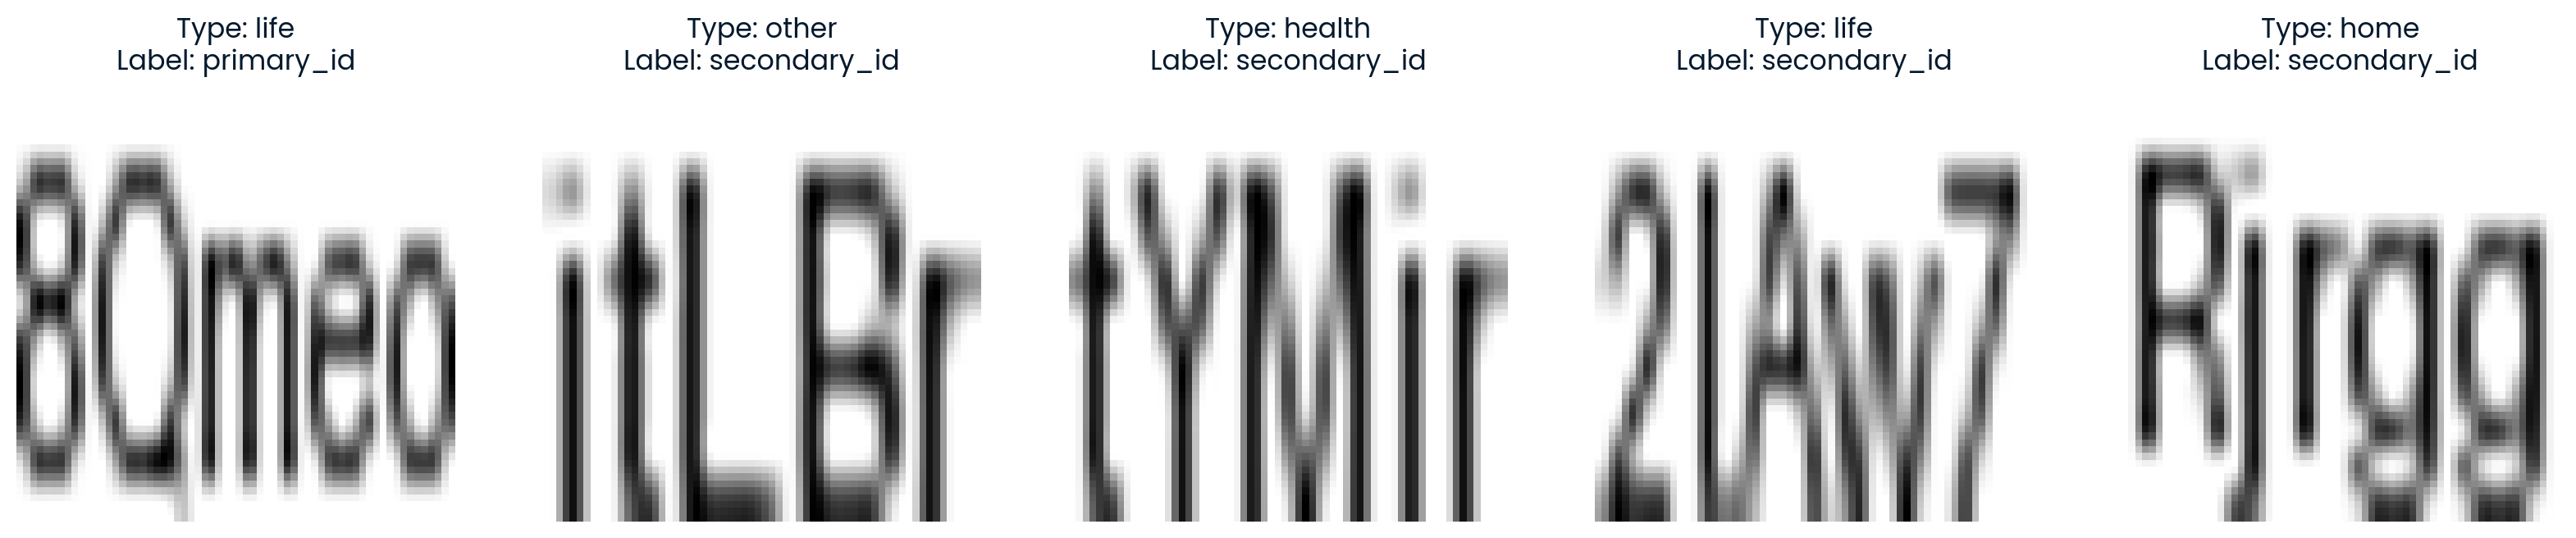

In [47]:
# Import the necessary libraries
import matplotlib.pyplot as plt
import numpy as np
from project_utils import ProjectDataset
import pickle 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

# Load the data
dataset = pickle.load(open('ocr_insurance_dataset.pkl', 'rb'))

# Define a function to visualize codes with their corresponding types and labels 
def show_dataset_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, min(num_images, len(dataset)), figsize=(20, 4))
    for ax, idx in zip(axes, np.random.choice(len(dataset), min(num_images, len(dataset)), False)):
        img, lbl = dataset[idx]
        ax.imshow((img[0].numpy() * 255).astype(np.uint8).reshape(64,64), cmap='gray'), ax.axis('off')
        ax.set_title(f"Type: {list(dataset.type_mapping.keys())[img[1].tolist().index(1)]}\nLabel: {list(dataset.label_mapping.keys())[list(dataset.label_mapping.values()).index(lbl)]}")
    plt.show()

# Inspect 5 codes images from the dataset
show_dataset_images(dataset)

In [48]:
# Custom collate function to ensure correct data unpacking
def custom_collate(batch):
    images = torch.stack([item[0][0] for item in batch])  # Extract first element of first tuple
    types = torch.stack([item[0][1] for item in batch])  # Extract second element of first tuple
    labels = torch.tensor([item[1] for item in batch])  # Take the label directly
    return images, types, labels

# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders with custom collate function
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=custom_collate)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate)

In [49]:
# Model Definition
class OCRModel(nn.Module):
    def __init__(self, num_types, num_labels, image_channels=1):
        super(OCRModel, self).__init__()
        
        # Image processing layers
        self.image_layer = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),  # Changed to 1 input and 16 output channels
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(16, 64, kernel_size=3, padding=1),  # Adjusted input channels to match previous layer's output
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Flatten()
        )
        
        # Calculate the flattened image feature size
        with torch.no_grad():
            dummy_input = torch.zeros(1, image_channels, 64, 64)
            image_features_size = self.image_layer(dummy_input).size(1)
        
        # Type embedding layer
        self.type_embedding = nn.Linear(num_types, 16)
        
        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(image_features_size + 16, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_labels)
        )
    
    def forward(self, image, type_tensor):
        # Process image through convolutional layers
        image_features = self.image_layer(image)
        
        # Process type through embedding
        type_embeddings = self.type_embedding(type_tensor)
        
        # Concatenate image features and type embeddings
        combined_features = torch.cat([image_features, type_embeddings], dim=1)
        
        # Pass through fully connected layers
        output = self.fc_layers(combined_features)
        
        return output

In [50]:
# Initialize model
model = OCRModel(
    num_types=len(dataset.type_mapping),
    num_labels=len(dataset.label_mapping)
)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for batch_images, batch_types, batch_labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(batch_images, batch_types)
        loss = criterion(outputs, batch_labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Calculate training metrics
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += batch_labels.size(0)
        train_correct += (predicted == batch_labels).sum().item()
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for batch_images, batch_types, batch_labels in val_loader:
            outputs = model(batch_images, batch_types)
            loss = criterion(outputs, batch_labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += batch_labels.size(0)
            val_correct += (predicted == batch_labels).sum().item()
    
    # Print epoch statistics
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss/len(train_loader):.4f}, '
          f'Train Accuracy: {100 * train_correct / train_total:.2f}%')
    print(f'Validation Loss: {val_loss/len(val_loader):.4f}, '
          f'Validation Accuracy: {100 * val_correct / val_total:.2f}%')

Epoch [1/10]
Train Loss: 0.7080, Train Accuracy: 46.25%
Validation Loss: 0.7110, Validation Accuracy: 35.00%
Epoch [2/10]
Train Loss: 0.6726, Train Accuracy: 58.75%
Validation Loss: 0.7219, Validation Accuracy: 35.00%
Epoch [3/10]
Train Loss: 0.7169, Train Accuracy: 48.75%
Validation Loss: 0.6922, Validation Accuracy: 65.00%
Epoch [4/10]
Train Loss: 0.7047, Train Accuracy: 48.75%
Validation Loss: 0.6872, Validation Accuracy: 65.00%
Epoch [5/10]
Train Loss: 0.6974, Train Accuracy: 46.25%
Validation Loss: 0.6859, Validation Accuracy: 65.00%
Epoch [6/10]
Train Loss: 0.6949, Train Accuracy: 55.00%
Validation Loss: 0.6864, Validation Accuracy: 65.00%
Epoch [7/10]
Train Loss: 0.6955, Train Accuracy: 48.75%
Validation Loss: 0.6883, Validation Accuracy: 65.00%
Epoch [8/10]
Train Loss: 0.6959, Train Accuracy: 46.25%
Validation Loss: 0.6887, Validation Accuracy: 65.00%
Epoch [9/10]
Train Loss: 0.6934, Train Accuracy: 52.50%
Validation Loss: 0.6886, Validation Accuracy: 65.00%
Epoch [10/10]
Train